In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

$$
ae^{1 - b\mathbf{C}}\mathbf{D} = \mathbf{f}
$$

a = abundance vector, |a| = n

b = (log-)PTR vector, |b| = n

C = DISTANCE matrix, |C| = n x m

Cij = inf if no such gene

D = gene -> seq matrix, |D| = m x k

f = observed coverages, |f| = k

# Basic implementation

In [28]:
# genomes
G1 = {'pos': [.2, .4, .7], 
      'seqs': [0, 1, 2]}
G2 = {'pos': [.1, .2, .9, .92], 
      'seqs': [0, 1, 3, 3]}
G3 = {'pos': [0.25, 0.5],
      'seqs': [4, 5]}

# sizes
n = 3
m = 9
k = 6

# a,b vectors
a = np.array([2, 3, 1.5])
b = np.log(np.array([1.4, 1.9, 1.1]))

# C and D vectors
C = np.inf * np.ones(shape=(n,m))
D = np.zeros(shape=(m,k))
i = 0
for g, genome in enumerate([G1,G2,G3]):
    pos = genome['pos']
    seqs = genome['seqs']
    j = i + len(pos)
    C[g,i:j] = pos
    for s, seq in enumerate(seqs):
        D[i+s,seq] = 1
    i = j
# TODO: clean this up a bit

# f vector
# f1 = b[:,None] * C
# f2 = a[:,None] - f1
# f3 = np.exp(f2)
# f4 = f3 @ D
# f = np.sum(f4, axis=0)
# f = np.sum(np.exp(a[:,None] - b[:,None] * C) @ D, axis=0)
f = np.sum(a[:,None] * np.exp(1 - b[:,None] * C) @ D, axis=0)

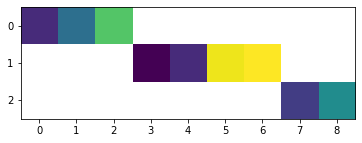

In [90]:
plt.imshow(C)

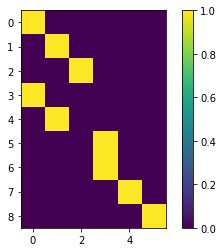

In [91]:
plt.imshow(D)
plt.colorbar()

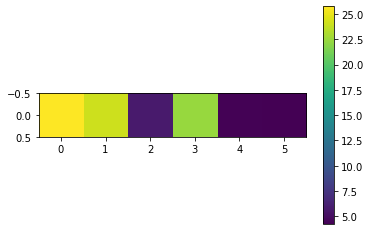

In [92]:
plt.imshow(f.reshape(1,-1))
plt.colorbar()

# Marginally nicer code

In [98]:
# Make a function

def compute_coverages(genomes, abundances, ptrs, return_full=False):
    """
    Run the coveragee computation in the forward direction.
    
    Args:
    -----
    genomes:
        A list of dicts keyed with 'pos' (distances to OOR) and 'seqs' (sequence indexes)
    abundances:
        A vector of abundances for each genome in "genomes," in order
    ptrs:
        A vector of log-PTRs for each genome in "genomes", in order
    return_full:
        Boolean. If True, returns tuple (a,b,C,D,f). Else just returns f.
    
    Returns:
    --------
    A vector of coverages for each OTU/sequence
    """
    # TODO: input validation
    
    # infer sizes
    n = len(genomes)
    m = np.sum([len(x['pos']) for x in genomes])
    k = len(set().union(*[set(x['seqs']) for x in genomes]))

    # C and D matrices
    dists = np.inf * np.ones(shape=(n,m))
    gene_to_seq = np.zeros(shape=(m,k))
    i = 0
    for g, genome in enumerate(genomes):
        pos = genome['pos']
        seqs = genome['seqs']
        j = i + len(pos)
        dists[g,i:j] = pos
        for s, seq in enumerate(seqs):
            gene_to_seq[i+s,seq] = 1
        i = j

    coverage_matrix = abundances[:,None] * np.exp(1 - ptrs[:,None] * dists) @ gene_to_seq
    
    if np.ndim(coverage_matrix) == 0:
        f = coverage_matrix
    else:
        f = np.sum(coverage_matrix, axis=0)
        # TODO: do we still need this control flow?
    
    if return_full:
        return abundances, ptrs, dists, gene_to_seq, f
    else:
        return f

# Test
f_old = f
a_old = a
b_old = b

f_new = compute_coverages([G1, G2, G3], a_old, b_old)

assert np.isclose(f_new, f).all()

# Sanity check: match PTR?

In [77]:
# Mini sanity check: PTR scaling for 1 genome
# Note that this should be independent of the abundance given

g_ptr = {'pos': [0,1], 'seqs': [0,1]}

abundance = np.array(100 * np.random.rand()).reshape(-1)
random_ptr = np.array(np.log(1 + np.random.rand())).reshape(-1)
f_ptr = compute_coverages([g_ptr], abundance, random_ptr)
# print(f_ptr[0] / f_ptr[1])

assert np.isclose(f_ptr[0] / f_ptr[1], np.exp(random_ptr))

1.662775884116986


In [93]:
# PTR scaling for multiple dimensions

n_ptrs = 3
abundances = 100 * np.random.rand(n_ptrs)
random_ptrs = np.log(1 + np.random.rand(n_ptrs))
test_genomes = [{'pos' : [0,1], 'seqs': [i*2, i*2+1]} for i in range(n_ptrs)]
f_ptrs = compute_coverages(test_genomes, abundances, random_ptrs)

assert np.isclose(f_ptrs[::2] / f_ptrs[1::2], np.exp(random_ptrs)).all()

PTR: 2.0


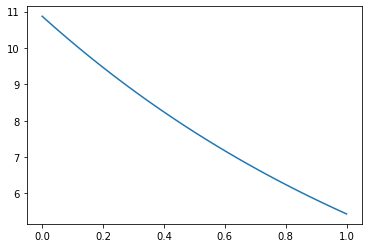

In [95]:
x = np.linspace(0,1)
y = 4 * np.exp(np.array(1) - np.log(2)*x)
plt.plot(x,y)
print(f"PTR: {y[0] / y[-1]}")

# Try with DB

In [84]:
db = pd.read_pickle("./data/db.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './data/db.pkl'

# Figure out gradients

In [114]:
def loss(yhat, y):
    """ MSE loss """
    return np.sum((yhat - y) ** 2)

def dloss(yhat, y):
    """ MSE loss grad: 2(y' - y)"""
    return 2 * (yhat - y)

Backprop:

$$
\begin{align*}
\hat{y} &= a e^{1 - bC}D\\
\\
L(y, \hat{y}) &= \sum_i (\hat{y}_i - y_i)^2\\
&= (\hat{y} - y)^T (\hat{y} - y)\\
\\
\frac{\partial L}{\partial \hat{y}} &= 2(\hat{y}-y)\\
\\
\frac{\partial L}{\partial a}
&= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial a}\\
&= 2(\hat{y} - y) e^{1-bC}D\\
\\
\frac{\partial L}{\partial e^{1-bC}D} 
&= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial e^{1-bC}D}\\
&= 2(\hat{y} - y) a\\
\\
\frac{\partial L}{\partial e^{1-bC}}
&= \frac{\partial L}{\partial e^{1-bC}D} \frac{\partial e^{1-bC}D}{\partial e^{1-bC}}\\
&= 2(\hat{y} - y)a D
\\
\frac{\partial L}{\partial 1-bC}
&= \frac{\partial L}{\partial e^{1-bC}} \frac{\partial e^{1-bC} }{\partial 1 - bC}\\
&= 2(\hat{y} - y)a D e^{1-bC}\\
\\
\frac{\partial L}{\partial b}
&= \frac{\partial L}{\partial 1-bC} \frac{\partial 1-bC}{\partial b}\\
&= -2(\hat{y} - y)a D e^{1-bC}C
\end{align*}
$$

In [99]:
# try to compute gradients

_,_,c,d,f = compute_coverages([G1, G2, G3], a_old, b_old, return_full=True)

In [125]:
# Grad_a

a_guess = np.random.rand(a.shape[0])
b_guess = np.random.rand(b.shape[0])
f_guess = compute_coverages([G1, G2, G3], a_guess, b_guess)
da1 = 2 * dloss(f_guess, f)
da2 = np.exp(1 - b_guess[:,None] * c) @ d
da3 = da1 * da2
da = da3

# Todo: just do this using autodiff
# Backprop interpretation:

"""
f and f_guess are vectors related to L through (f - f')T * (f - f') = L
each element f_i contributes to L to the extent that (f_i - f_i')^2 deviates from 0
want to follow gradients s.t. f_i' comes close to f_i

make use of this info:
#genomes = 3
#seqs = 6
#genes = 9

hmm...

losses are in terms of number of seqs but nothing else really is... the D matrix is the key here

we have the following formula:
dL/da = 2(f' - f) * (exp(1 - bC) @ D)

"""
da

array([[-100.89881925,  -87.35634322,  -29.88241248,   -0.        ,
          -0.        ,   -0.        ],
       [-103.26348132,  -91.49888516,   -0.        ,  -88.67595279,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
         -21.27295477,  -18.40367556]])

In [143]:
# Grad_b

db1 = -2 * dloss(f_guess, f)
# db2 = db1 * a_guess
# db3 = db2 @ d
# db2 = a_guess @ d
# db3 = db1 * db2
# db4 = db3 @ np.exp(1 - b_guess[:,None] * c)
# db5 = db4 @ C
# db = db5

db2 = np.exp(1 - b_guess[:,None] * c)
db3 = db2 * c
# db4 = d @ db3
db4 = db3 @ d
db5 = a @ db4
db6 = db1 * db5
db = db6

"""
What to make of the aD term here?
"""

db

<ipython-input-143-aa4012adca5c>:13: RuntimeWarning: invalid value encountered in multiply
  db3 = db2 * c


array([nan, nan, nan, nan, nan, nan])

In [142]:
print(db1.shape)
print(db2.shape)
print(db3.shape)
# print(db4.shape)
print(a.shape)
print(c.shape)
print(d.shape)

(6,)
(3, 9)
(3, 9)
(3,)
(3, 9)
(9, 6)


In [131]:
print(db1.shape)
print(db2.shape)
print(db3.shape)
print(d.shape)

(6,)
(3,)


NameError: name 'db3' is not defined

In [111]:
db2

array([-326.21465922, -329.02516668, -266.73446776])

In [112]:
d

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])